In [1]:
import tensorflow as tf
import os

print(tf.__version__)

2.0.0


In [2]:
# for gpu in tf.config.experimental.list_physical_devices('GPU'):
#     tf.config.experimental.set_memory_growth(gpu, True)

#### VGG块的组成规律是：连续使用数个相同的填充为1、窗口形状为 3×3 的卷积层后接上一个步幅为2、窗口形状为 2×2 的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用vgg_block函数来实现这个基础的VGG块，它可以指定卷积层的数量num_convs和输出通道数num_channels

In [3]:
# 定义一个重复使用的vgg_block块

def vgg_block(net, num_convs, num_channels):
    # 参数说明：num_convs:卷积的个数，num_channels为卷积核的个数， num_convs个卷积核+maxpool2d
    for _ in range(num_convs):
        net.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))

    net.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return net


In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [5]:
# 当然也可以自己自定义layer层，但是学会使用Sequential方式堆叠规范的层，更加简单方便

def vgg_net(conv_arch):
    vgg = tf.keras.models.Sequential()
    for n, k in conv_arch:
        vgg_block(vgg,n, k)
    # 注意 sequential.add() 可以直接添加一个叠加层，但是这个叠加层会作为一个整体,这里就逐个添加了，方便展示模型结构
#         net.add(tf.keras.models.Sequential([tf.keras.layers.Flatten(),
#              tf.keras.layers.Dense(4096,activation='relu'),
#              tf.keras.layers.Dropout(0.5),
#              tf.keras.layers.Dense(4096,activation='relu'),
#              tf.keras.layers.Dropout(0.5),
#              tf.keras.layers.Dense(10,activation='sigmoid')]))
    vgg.add(tf.keras.layers.Flatten())
    vgg.add(tf.keras.layers.Dense(4096,activation='relu'))
    vgg.add(tf.keras.layers.Dropout(0.5))
    vgg.add(tf.keras.layers.Dense(4096,activation='relu'))
    vgg.add(tf.keras.layers.Dropout(0.5))
    vgg.add(tf.keras.layers.Dense(10,activation='sigmoid'))
    return vgg

vgg = vgg_net(conv_arch)
vgg

In [6]:
X = tf.random.uniform((1,224,224,1))
for blk in vgg.layers:
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

conv2d output shape:	 (1, 224, 224, 64)
max_pooling2d output shape:	 (1, 112, 112, 64)
conv2d_1 output shape:	 (1, 112, 112, 128)
max_pooling2d_1 output shape:	 (1, 56, 56, 128)
conv2d_2 output shape:	 (1, 56, 56, 256)
conv2d_3 output shape:	 (1, 56, 56, 256)
max_pooling2d_2 output shape:	 (1, 28, 28, 256)
conv2d_4 output shape:	 (1, 28, 28, 512)
conv2d_5 output shape:	 (1, 28, 28, 512)
max_pooling2d_3 output shape:	 (1, 14, 14, 512)
conv2d_6 output shape:	 (1, 14, 14, 512)
conv2d_7 output shape:	 (1, 14, 14, 512)
max_pooling2d_4 output shape:	 (1, 7, 7, 512)
flatten output shape:	 (1, 25088)
dense output shape:	 (1, 4096)
dropout output shape:	 (1, 4096)
dense_1 output shape:	 (1, 4096)
dropout_1 output shape:	 (1, 4096)
dense_2 output shape:	 (1, 10)


#### 因为VGG-11计算上比AlexNet更加复杂，出于测试的目的我们构造一个通道数更小，或者说更窄的网络在Fashion-MNIST数据集上进行训练。

In [7]:
ratio = 8
# 将每个卷积层的输出通道数较少为 1/ 8
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg_net(small_conv_arch)

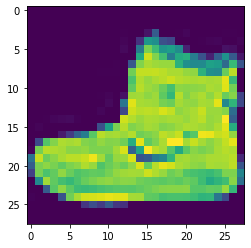

<Figure size 360x360 with 0 Axes>

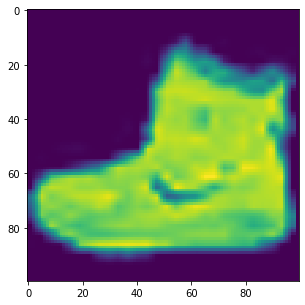

In [8]:
# 获取数据
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 熟悉一下，tf.image.resize_with_pad 函数
def resize(x):
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=100, target_width=100, method='bilinear')
    x = tf.squeeze(x)
    return x

img = x_train[0]
img2 = resize(img)
plt.imshow(img)
plt.figure(figsize=(5,5))
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(img2)
plt.show()

In [9]:
# 数据预处理
def data_scale(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=224,target_width=224)
    
    return x, y
# 由于笔记本训练太慢了，使用1000条数据，跑一下先,算力够的可以直接使用全部数据更加明显
train_db = tf.data.Dataset.from_tensor_slices((x_train[0:1000],y_train[0:1000])).shuffle(20).map(data_scale).batch(128)
test_db = tf.data.Dataset.from_tensor_slices((x_test[0:1000],y_test[0:1000])).shuffle(20).map(data_scale).batch(128)

In [12]:
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.Adam(lr=1e-1)
loss = tf.keras.losses.sparse_categorical_crossentropy
net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
net.fit_generator(train_db, epochs=5, validation_data=test_db)    # 这里就不跑太多轮了，有机器可以自己调参跑个好的结果
net.summary()

Epoch 1/5
8/8 [==============================] - 55s 7s/step - loss: 11.3158 - accuracy: 0.1000 - val_loss: 12.4607 - val_accuracy: 0.1050
Epoch 2/5
8/8 [==============================] - 57s 7s/step - loss: 12.4612 - accuracy: 0.1040 - val_loss: 12.4571 - val_accuracy: 0.1050
Epoch 3/5
8/8 [==============================] - 57s 7s/step - loss: 12.4611 - accuracy: 0.1040 - val_loss: 12.4680 - val_accuracy: 0.1050
Epoch 4/5
8/8 [==============================] - 56s 7s/step - loss: 12.4486 - accuracy: 0.1040 - val_loss: 12.4607 - val_accuracy: 0.1050
Epoch 5/5
8/8 [==============================] - 58s 7s/step - loss: 12.4424 - accuracy: 0.1040 - val_loss: 12.4643 - val_accuracy: 0.1050
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            multiple                  80        
_________________________________________________________________
max_pooling2d_5 (Ma

In [16]:
# net.save('vgg.h5')
X = tf.random.uniform((1,224,224,1))

for blk in vgg.layers:
    print('input shape:\t', X.shape)
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

(1, 224, 224, 1)
conv2d output shape:	 (1, 224, 224, 64)
(1, 224, 224, 64)
max_pooling2d output shape:	 (1, 112, 112, 64)
(1, 112, 112, 64)
conv2d_1 output shape:	 (1, 112, 112, 128)
(1, 112, 112, 128)
max_pooling2d_1 output shape:	 (1, 56, 56, 128)
(1, 56, 56, 128)
conv2d_2 output shape:	 (1, 56, 56, 256)
(1, 56, 56, 256)
conv2d_3 output shape:	 (1, 56, 56, 256)
(1, 56, 56, 256)
max_pooling2d_2 output shape:	 (1, 28, 28, 256)
(1, 28, 28, 256)
conv2d_4 output shape:	 (1, 28, 28, 512)
(1, 28, 28, 512)
conv2d_5 output shape:	 (1, 28, 28, 512)
(1, 28, 28, 512)
max_pooling2d_3 output shape:	 (1, 14, 14, 512)
(1, 14, 14, 512)
conv2d_6 output shape:	 (1, 14, 14, 512)
(1, 14, 14, 512)
conv2d_7 output shape:	 (1, 14, 14, 512)
(1, 14, 14, 512)
max_pooling2d_4 output shape:	 (1, 7, 7, 512)
(1, 7, 7, 512)
flatten output shape:	 (1, 25088)
(1, 25088)
dense output shape:	 (1, 4096)
(1, 4096)
dropout output shape:	 (1, 4096)
(1, 4096)
dense_1 output shape:	 (1, 4096)
(1, 4096)
dropout_1 output shape